In [1]:
#依赖包导入cell，请执行此cell导入相关依赖包
from sklearn.cluster import KMeans,DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#函数定义cell，请执行此cell定义相关函数

#数据预处理
def data_prepro(df):
    df_o = df
    #获取风速范围内数据
    df = df[df['WindSpeed']>=2.5]
    df = df[df['WindSpeed']<=25]
    #获取功率范围内数据
    df = df[df['Power']>=0]
    df = df[df['Power']<=2000]
    return df,df_o.drop(df.index)


In [3]:
#函数定义cell，请执行此cell定义相关函数

#获得内限
def get_F(data,key):
    interval = len(data)
    #计算四分位数
    Q1=Q2=Q3=0
    #当分组大小为偶数时
    if interval % 2 == 0:
        #获取中位数
        shift = int(interval/2)
        Q2 = (data[key].iloc[shift-1]+data[key].iloc[shift])/2         
        #计算四分位数Q1，Q3
        sub_interval = interval/2
        if sub_interval%2 == 0:
            sub_shift = int(sub_interval/2)
            Q1 = (data[key].iloc[sub_shift-1]+data[key].iloc[sub_shift])/2   
            Q3 = (data[key].iloc[shift+sub_shift-1]+data[key].iloc[shift+sub_shift])/2
        else:
            sub_shift = int(sub_interval/2+0.5)
            Q1 = data[key].iloc[sub_shift-1]
            Q3 = data[key].iloc[shift-1+sub_shift]
    #当分组大小为奇数时
    else:
        #获取中位数
        shift = int((interval+1)/2)
        Q2 = data[key].iloc[shift-1]
        k = int(interval/4)
        #计算四分位数Q1，Q3
        if interval % 4 == 3:
            Q1 = 0.75*data[key].iloc[k] +0.25*data[key].iloc[k+1]
            Q3 = 0.25*data[key].iloc[3*k+1] +0.75*data[key].iloc[3*k+2]
        else:
            Q1 = 0.25*data[key].iloc[k-1] +0.75*data[key].iloc[k]
            Q3 = 0.75*data[key].iloc[3*k] +0.25*data[key].iloc[3*k+1]
    
    #获得四分位距
    I_QR = Q3-Q1
    #获得内限
    F1 = Q1-1.5*I_QR
    Fu = Q3+1.5*I_QR
    return F1,Fu

In [4]:
#函数定义cell，请执行此cell定义相关函数

#横向四分位
def quartile_x(df,Pe=2000, ratio=25):
    result_df = df[0:0]
    delete_df = df[0:0]

    #获得分组数量
    num = int(Pe/ratio)
    #关键字
    key = 'WindSpeed'
    key_sort = 'Power'
    
    #按分组大小对数据进行划分，并处理每个分组
    for i in range(num):
        #获得每个分组内的数据
        start = i*ratio
        end = (i+1)*ratio
        data = df[df[key_sort]>=start]
        data = data[data[key_sort]<end]
        data = data.sort_values(by=key)
        interval = len(data)
        
        if interval<4:
            result_df = result_df.append(data)
            continue

        F1,Fu = get_F(data,key)
        #过滤数据
#         delete_df = delete_df.append(data[data[key]<F1])
#         delete_df = delete_df.append(data[data[key]>Fu])
        data = data[data[key]>=F1]
        data = data[data[key]<=Fu]
        result_df = result_df.append(data)

    return result_df,df.drop(result_df.index)

In [5]:
#函数定义cell，请执行此cell定义相关函数

#纵向四分位
def quartile_y(df,Pe=25, ratio=0.5):
    result_df = df[0:0]
#     delete_df = df[0:0]

    #获得分组数量
    num = int(Pe/ratio)
    #关键字
    key = 'Power'
    key_sort = 'WindSpeed'
    #按分组大小对数据进行划分，并处理每个分组
    for i in range(num):
        #获得每个分组内的数据
        start = i*ratio
        end = (i+1)*ratio
        data = df[df[key_sort]>=start]
        data = data[data[key_sort]<end]
        data = data.sort_values(by=key)
        interval = len(data)

        if interval<4:
            result_df = result_df.append(data)
            continue

        F1,Fu = get_F(data,key)
        #过滤数据
#         delete_df = delete_df.append(data[data[key]>Fu])
        data = data[data[key]<=Fu]
        result_df = result_df.append(data)
        
    return result_df,df.drop(result_df.index)

In [6]:
#函数定义cell，请执行此cell定义相关函数

#聚类
def cluster_data(df,Pe=25, ratio=0.5, T=400):
    result_df = df[0:0]
    delete_df = df[0:0]
    result_df['label']=0
    delete_df['label']=1
    #获得分组数量
    num = int(Pe/ratio)
    #关键字
    key = 'Power'
    key_sort = 'WindSpeed'
    #按分组大小对数据进行划分，并处理每个分组
    for i in range(num):
        #获得每个分组内的数据
        start = i*ratio
        end = (i+1)*ratio
        data = df[df[key_sort]>=start]
        data = data[data[key_sort]<end]
        data = data.sort_values(by=key)
        interval = len(data)

        if interval<5:
            data['label']=0
            result_df = result_df.append(data)
            continue

        loan = np.array(data[[key,key_sort]])
        clf=KMeans(n_clusters=5,random_state=9)
        clf = clf.fit(loan)
        data['label']=clf.labels_
        w_max = max(clf.cluster_centers_[:,0])
        for index,w in enumerate(clf.cluster_centers_[:,0]):
            if w_max - w <= T:
                result_df = result_df.append(data[data['label']==index])
            else:
                delete_df = delete_df.append(data[data['label']==index])
                
    result_df['label']=0
    delete_df['label']=1
    
    return result_df,delete_df

In [38]:
#实验cell，用于调试代码，观察实验结果
#第一步，导入数据
df = pd.read_csv("dataset.csv")
df = df[df['WindNumber']==2]

In [39]:
#实验cell，用于调试代码，观察实验结果
#第二步，数据分析

#异常检测
print(len(df))
df,dl0 = data_prepro(df)
# print("输出：{}，下一步输入:{}".format(len(df)+len(dl0),len(df)))
df,dl = quartile_x(df)
# print("输出：{}，下一步输入:{}".format(len(df)+len(dl),len(df)))
df,dl2 = quartile_y(df)
# print("输出：{}，下一步输入:{}".format(len(df)+len(dl2),len(df)))
df,dl3 = cluster_data(df)
# print("输出：{}，下一步输入:{}".format(len(df)+len(dl3),len(df)))

#数据分组
dl0['label']=1
dl['label']=1
dl2['label']=1
dl = dl.append(dl0)
dl = dl.append(dl2)
dl = dl.append(dl3)


38855


In [41]:
dt = df[(df['Power']<1250) & (df['WindSpeed']>12)]
df = df.drop(dt.index)
dl = dl.append(dt)

正常数据: 23237 异常数据: 15618


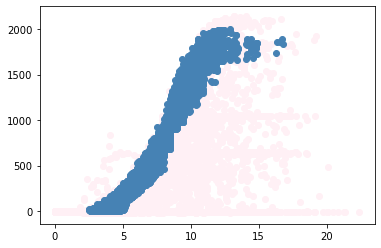

In [42]:
#实验cell，用于调试代码，观察实验结果
#第三步，结果绘图

plt.scatter(dl['WindSpeed'],dl['Power'],c='#FFF0F5')
plt.scatter(df['WindSpeed'],df['Power'],c='#4682B4')
print('正常数据:',len(df),'异常数据:',len(dl))
plt.show()

In [43]:
df = df.append(dl)
d_out = df[['WindNumber','Time','label']]

In [46]:
df2 = pd.read_csv("submission - 85.csv")
print(len(df2))
df_other = df2[df2['WindNumber']!=2]
print(len(df_other))

497837
458982


In [48]:
df_other = df_other[['WindNumber','Time','label']]
d_out = df_other.append(d_out)
print(len(d_out))

In [50]:
d_out.to_csv("submission2.csv",index=None)

In [134]:
#输出cell，用于输出结果文件
#第一步，处理1号风机

df = pd.read_csv("dataset.csv")
df = df[df['WindNumber']==1]
#异常检测
df,dl0 = data_prepro(df)
df,dl = quartile_x(df)
df,dl2 = quartile_y(df)
df,dl3 = cluster_data(df)
#数据分组
dl0['label']=1
dl['label']=1
dl2['label']=1
dl = dl.append(dl0)
dl = dl.append(dl2)
dl = dl.append(dl3)

df = df.append(dl)
d_out = df[['WindNumber','Time','label']]

In [135]:
#输出cell，用于输出结果文件
#第二步，处理2至12号风机

df_source = pd.read_csv("dataset.csv")
for i in range(2,13):
    print("正在进行{}".format(i))
    df = df_source[df_source['WindNumber']==i]
    print("原始数据量{}".format(len(df)))
    #异常检测
    df,dl0 = data_prepro(df)
    df,dl = quartile_x(df)
    df,dl2 = quartile_y(df)
    df,dl3 = cluster_data(df)

#     print("异常数据{},{},{}".format(len(dl),len(dl2),len(dl3)))
    #数据分组
    dl0['label']=1
    dl['label']=1
    dl2['label']=1
    dl = dl.append(dl0)
    dl = dl.append(dl2)
    dl = dl.append(dl3)
    print('【总量】正常数据:',len(df),'异常数据:',len(dl))
    print()
    df = df.append(dl)
    d_out = d_out.append(df[['WindNumber','Time','label']])


正在进行2
原始数据量38855
【总量】正常数据: 23269 异常数据: 15586

正在进行3
原始数据量38995
【总量】正常数据: 20889 异常数据: 18106

正在进行4
原始数据量44335
【总量】正常数据: 28445 异常数据: 15890

正在进行5
原始数据量50962
【总量】正常数据: 29847 异常数据: 21115

正在进行6
原始数据量45592
【总量】正常数据: 25490 异常数据: 20102

正在进行7
原始数据量43324
【总量】正常数据: 24142 异常数据: 19182

正在进行8
原始数据量38470
【总量】正常数据: 25619 异常数据: 12851

正在进行9
原始数据量42824
【总量】正常数据: 27241 异常数据: 15583

正在进行10
原始数据量30184
【总量】正常数据: 24189 异常数据: 5995

正在进行11
原始数据量36848
【总量】正常数据: 27455 异常数据: 9393

正在进行12
原始数据量46721
【总量】正常数据: 21947 异常数据: 24774



In [139]:
#输出cell，用于输出结果文件
#第三步，查看异常数据数量

print(len(d_out[d_out['label']==1]),len(df_source))

193721 497837


In [137]:
#输出cell，用于输出结果文件
#第四步，导出结果文件

d_out.to_csv("submission.csv")

In [191]:
#测试cell，不需要执行，用于个人进行测试

d = df[df['WindSpeed']>=10]
dd = dd[dd['WindSpeed']<=12]

In [153]:
#测试cell，不需要执行，用于个人进行测试

dt = dd
dd = dd[0:6]
loan = np.array(dd[['Power','WindSpeed']])
labels=KMeans(n_clusters=5 ,random_state=9).fit_predict(loan)
plt.scatter(dd['WindSpeed'],dd['Power'],c=labels)
plt.show()
dd = dt

ValueError: n_samples=4 should be >= n_clusters=5

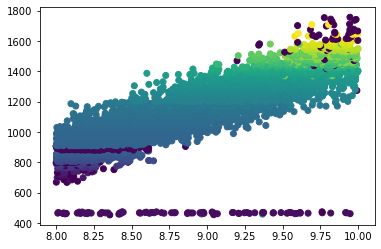

In [128]:
#测试cell，不需要执行，用于个人进行测试

loan = np.array(dd[['Power','WindSpeed']])
labels=DBSCAN(eps=0.9,min_samples=2).fit_predict(loan)
plt.scatter(dd['WindSpeed'],dd['Power'],c=labels)
plt.show()